In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from wordcloud import WordCloud, STOPWORDS

In [2]:
def data_form():
    try:
        url = 'https://www.ecdc.europa.eu/sites/default/files/documents/'
        today = datetime.now().strftime(
            url+'COVID-19-geographic-disbtribution-worldwide-%Y-%m-%d.xlsx')
        df = pd.read_excel(today)
        df.to_csv('last_updated.csv')
    except:
        try:
            today = (datetime.now()-timedelta(days=1)).strftime(url +
                                                                'COVID-19-geographic-disbtribution-worldwide-%Y-%m-%d.xlsx')
            df = pd.read_excel(today)
            df.to_csv('last_updated.csv')
        except:
            df = pd.read_csv('last_updated.csv')
    df = df.groupby('Countries and territories').first()
    try:
        date = sorted(df['DateRep'], reverse=True)[0].strftime('%d %b,%Y')
    except:
        date = sorted(df['DateRep'], reverse=True)[0]
        date = [int(i) for i in date.split('-')]
        date = datetime.datetime(*date)
        date = date.strftime('%d %b,%Y ')
    df = df.drop(['Day', 'Month', 'Year', 'GeoId', 'DateRep'], axis=1)
    for i in df.columns:
        df[i] = pd.to_numeric(df[i])
    df = df.sort_values(by=['Cases'], ascending=False)
    df = df.loc[~(df <= 0).any(axis=1)]
    return df, date


def short_country(x):
    country = x.split('_')
    if len(country) > 1:
        x = ''.join([i[0] for i in country if i not in['of']])
    return x


def top_value(df, date, val=None):
    full_data = {}
    if val == None:
        val = df.shape[0]
    df = df[:val]
    full_data['country'] = list(map(short_country, df.index.values))
    full_data['affected'] = df.Cases.values
    full_data['death'] = df.Deaths.values

    full_data['per_affected'] = df.Cases.values / \
        (df.Deaths.values+df.Cases.values)
    full_data['per_death'] = df.Deaths.values / \
        (df.Deaths.values+df.Cases.values)

    full_data['date'] = date
    return full_data


def data_plot(main_data, save=False):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)

    plt.bar(main_data['country'], main_data['per_affected'],
            color='limegreen', edgecolor='white', label='Affected')
    plt.bar(main_data['country'], main_data['per_death'], bottom=main_data['per_affected'],
            color='darkorange', edgecolor='white', label='Death')

    plt.xlabel("Country Name", fontsize=25)
    plt.ylabel('Patient Number in Percentage', fontsize=25)
    plt.title('Corona impact only on '+main_data['date'], fontsize=25)

    ax.set_yticklabels([0, 20, 40, 60, 80, 100])
    xtickNames = ax.set_xticklabels(main_data['country'])

    ax.legend(fontsize=15, loc='lower left')

    plt.setp(xtickNames, rotation=30, fontsize=15)
    if save:
        plt.savefig('Corona.png')
    plt.show()


def show_wordcloud(main_data, save=False):
    stopwords = set(STOPWORDS)

    data = data = {i: j for i, j in zip(
        main_data['country'], main_data['death'])}
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=len(data),
        max_font_size=80,
        scale=3,
        random_state=200
    ).generate_from_frequencies(data).recolor(random_state=63008)

    plt.figure(figsize=(16, 8), facecolor='white', edgecolor='blue')
    plt.title('Corona impact only on ' +
              main_data['date'], fontsize=25)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud)
    if save:
        plt.savefig('Corona Stat Country wise.png')
    plt.show()

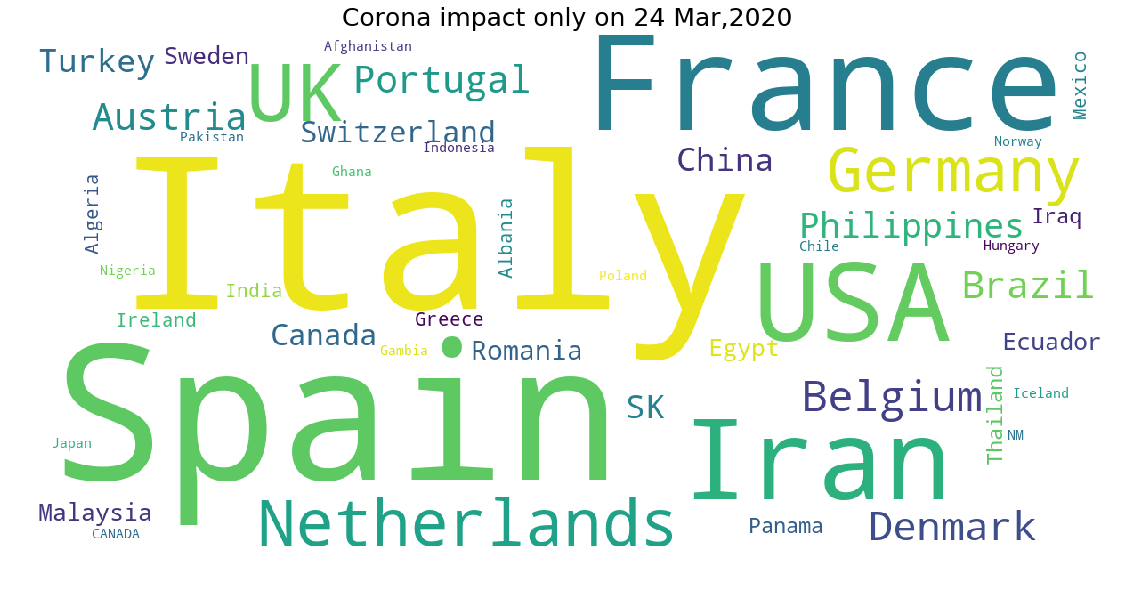

In [3]:
df, date = data_form()
main_data = top_value(df, date)
show_wordcloud(main_data, True)

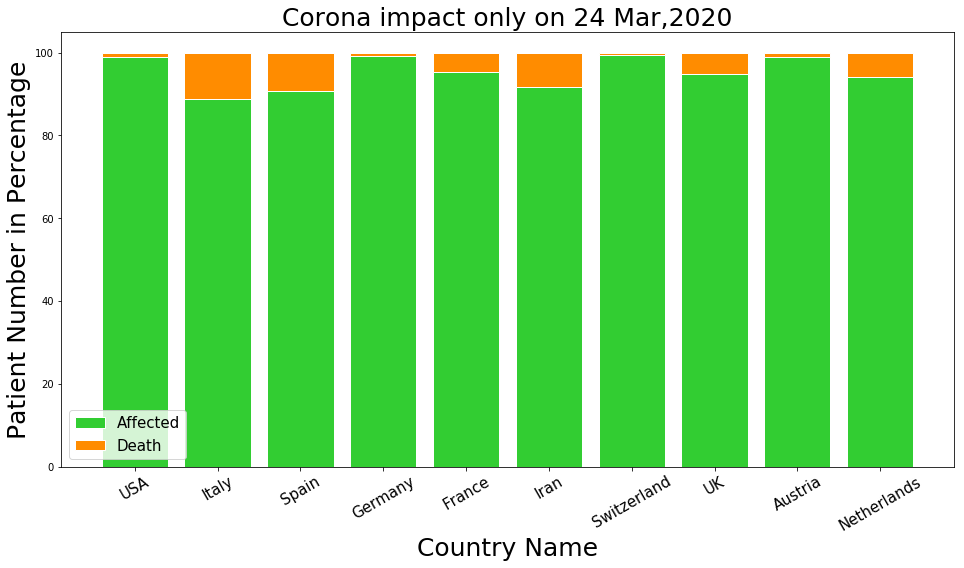

In [4]:
df, date = data_form()
number_bar = 10
main_data = top_value(df, date, number_bar)
data_plot(main_data, True)